In [141]:
# -*- coding: utf-8 -*-
# Authors: Chitta Ranjan <cran2367@gmail.com>
#
# License: BSD 3 clause

In [1]:
import numpy as np
import pandas as pd
from itertools import chain
import warnings

########
from sklearn.preprocessing import LabelEncoder
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
np.random.seed(7) # fix random seed for reproducibility
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import sklearn.metrics
import time

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

from sgt import Sgt

Using TensorFlow backend.


In [2]:
sgt = Sgt()

## Protein Sequence Data Analysis

The data used here is taken from www.uniprot.org. This is a public database for proteins. The data contains the protein sequences and their functions. In the following, we will demonstrate 
- clustering of the sequences.
- classification of the sequences with the functions as labels.

In [3]:
train = pd.read_csv("data/3Classes_train.csv", sep="\t")
train.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh
0,Q9H3M7,Mostly Organellar,MVMFKKIKSFEVVFNDPEKVYGSGEKVAGRVIVEVCEVTRVKAVRI...,391
1,P22314,Mostly Cytosolic,MSSSPLSKKRRVSGPDPKPGSNCSPAQSVLSEVPSVPTNGMAKNGS...,1058
2,P27348,Mostly Cytosolic,MEKTELIQKAKLAEQAERYDDMATCMKAVTEQGAELSNEERNLLSV...,245
3,Q9Y2V7,Mostly Cytosolic,MAEGSGEVVAVSATGAANGLNNGAGGTSATTCNPLSRKLHKILETR...,657
4,Q53F19,Mostly Nuclear,MAAVRGLRVSVKAEAPAGPALGLPSPEAESGVDRGEPEPMEVEEGE...,620


In [4]:
X_train =train['Sequence']

In [6]:
X_train.head()

0    MVMFKKIKSFEVVFNDPEKVYGSGEKVAGRVIVEVCEVTRVKAVRI...
1    MSSSPLSKKRRVSGPDPKPGSNCSPAQSVLSEVPSVPTNGMAKNGS...
2    MEKTELIQKAKLAEQAERYDDMATCMKAVTEQGAELSNEERNLLSV...
3    MAEGSGEVVAVSATGAANGLNNGAGGTSATTCNPLSRKLHKILETR...
4    MAAVRGLRVSVKAEAPAGPALGLPSPEAESGVDRGEPEPMEVEEGE...
Name: Sequence, dtype: object

In [7]:
test = pd.read_csv("data/3Classes_test.csv", sep="\t")
X_test =test['Sequence']
X_test.head()

0    MVDLTQVMDDEVFMAFASYATIILSKMMLMSTATAFYRLTRKVFAN...
1    MAAAAATKILLCLPLLLLLSGWSRAGRADPHSLCYDITVIPKFRPG...
2    MAHCVTLVQLSISCDHLIDKDIGSKSDPLCVLLQDVGGGSWAELGR...
3    MALYQRWRCLRLQGLQACRLHTAVVSTPPRWLAERLGLFEELWAAQ...
4    MQSREDVPRSRRLASPRGGRRPKRISKPSVSAFFTGPEELKDTAHS...
Name: Sequence, dtype: object

In [8]:
def split(word): 
    return [char for char in word] 

train_sequences = [split(x) for x in X_train]
test_sequences = [split(x) for x in X_test]

### Generating sequence embeddings

In [9]:
sgt = Sgt(kappa = 10, lengthsensitive = False)

In [10]:
embedding = sgt.fit_transform(corpus=train_sequences)

In [11]:
embedding

array([[0.22508763, 0.23306572, 0.21442049, ..., 0.        , 0.        ,
        0.        ],
       [0.21185905, 0.20316205, 0.19653654, ..., 0.        , 0.        ,
        0.        ],
       [0.20970972, 0.26138251, 0.08395396, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.21780123, 0.08522225, 0.23978566, ..., 0.        , 0.        ,
        0.        ],
       [0.2099131 , 0.01183957, 0.23306625, ..., 0.        , 0.        ,
        0.        ],
       [0.19502635, 0.0790251 , 0.1867104 , ..., 0.        , 0.        ,
        0.        ]])

#### Sequence Clustering
We perform PCA on the sequence embeddings and then do kmeans clustering.

In [12]:
pca = PCA(n_components=2)
pca.fit(embedding)
X=pca.transform(embedding)

print(np.sum(pca.explained_variance_ratio_))
df = pd.DataFrame(data=X, columns=['x1', 'x2'])
df.head()

0.10690606575158915


,x1,x2
0,-0.176735,-0.002150
1,-0.694781,0.179760
2,0.444302,0.002981
3,-0.362661,0.122259
4,-0.109480,-0.006984


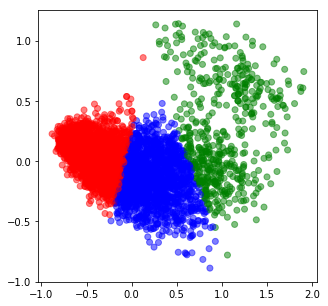

In [13]:
kmeans = KMeans(n_clusters=3, max_iter =300)
kmeans.fit(df)

labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(5, 5))
colmap = {1: 'r', 2: 'g', 3: 'b'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df['x1'], df['x2'], color=colors, alpha=0.5, edgecolor=colors)

#### Sequence Classification
We perform PCA on the sequence embeddings and then do kmeans clustering.

In [30]:
Y_train = train['Global classifier2']
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_y_train = encoder.transform(Y_train)

(4446,)

In [31]:
encoded_y_train = encoded_y_train.reshape(-1, 1)
encoded_y_train

array([[2],
       [0],
       [0],
       ...,
       [2],
       [2],
       [2]])

In [32]:
encoded_y_train.shape

(4446, 1)

In [33]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()
y_train_OH = onehotencoder.fit_transform(encoded_y_train).toarray()

/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [28]:
X_train.shape

(4001, 441)

We will perform a 10-fold cross-validation to measure the performance of the classification model.

In [49]:
kfold = 10
X = pd.DataFrame(embedding)
y = y_train_OH

random_state = 1

test_F1 = np.zeros(kfold)
skf = KFold(n_splits = kfold, shuffle = True, random_state = random_state)
k = 0
epochs = 50
batch_size = 128

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = X_train.as_matrix(columns = None)
    X_test = X_test.as_matrix(columns = None)
    
    model = Sequential()
    model.add(Dense(128, input_shape = (X_train.shape[1],), init = 'uniform')) 
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, init='uniform'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train ,batch_size=batch_size, epochs=epochs, verbose = False)
        
    #y_pred = model.predict_proba(X_test)
    #y_pred = y_pred.round()
    #y_pred = y_pred.astype(int)
    #y_train_pred = model.predict_proba(X_train)
    #y_train_pred = y_train_pred.round()
    #y_train_pred = y_train_pred.astype(int)
    loss, acc = model.evaluate(X_test, y_test)
    print("Test accuracy = ", acc)
    
#print ('Average test accuracy', np.mean(test_F1))


/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_shape=(441,), kernel_initializer="uniform")`
/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="uniform")`
/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_initializer="uniform")`


445/445 [==============================] - 1s 1ms/step
Test accuracy =  0.6314606666564941
445/445 [==============================] - 1s 2ms/step
Test accuracy =  0.6112359762191772
445/445 [==============================] - 1s 2ms/step
Test accuracy =  0.5752809047698975
445/445 [==============================] - 1s 2ms/step
Test accuracy =  0.5955055952072144
445/445 [==============================] - 1s 2ms/step
Test accuracy =  0.5910112261772156
445/445 [==============================] - 1s 2ms/step
Test accuracy =  0.6337078809738159
444/444 [==============================] - 1s 2ms/step
Test accuracy =  0.6148648858070374
444/444 [==============================] - 1s 2ms/step
Test accuracy =  0.5788288116455078
444/444 [==============================] - 1s 2ms/step
Test accuracy =  0.587837815284729
444/444 [==============================] - 1s 2ms/step
Test accuracy =  0.6126126050949097


In [ ]:
    
    y_pred = model.predict_proba(X_test)
    y_pred = y_pred.round()
    y_pred = y_pred.astype(int)
    y_train_pred = model.predict_proba(X_train)
    y_train_pred = y_train_pred.round()
    y_train_pred = y_train_pred.astype(int)
    print ('Test F1 for fold', k+1, sklearn.metrics.f1_score(y_test, y_pred) )
    test_F1[k] = sklearn.metrics.f1_score(y_test, y_pred)
    k+=1
    
print ('Average test accuracy', np.mean(test_F1))

#### Applying PCA on the embeddings
The embeddings are sparse. We, therefore, apply PCA on the embeddings.

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=35)
pca.fit(embedding)
X = pca.transform(embedding)
print(np.sum(pca.explained_variance_ratio_))

0.2874885993928512


#### Building an LSTM Classifier on the sequences for comparison
We built an LSTM Classifier on the sequences to compare the accuracy.

In [51]:
X = darpa_data['seq']
encoded_X = np.ndarray(shape=(len(X),), dtype=list)
for i in range(0,len(X)):
    encoded_X[i]=X.iloc[i].split("~")

NameError: name 'darpa_data' is not defined

In [182]:
max_seq_length = np.max(darpa_data['seqlen'])
encoded_X = sequence.pad_sequences(encoded_X, maxlen=max_seq_length)

In [183]:
kfold = 3
random_state = 11

test_F1 = np.zeros(kfold)
time_k = np.zeros(kfold)

epochs = 50
batch_size = 15
skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
k = 0

for train_index, test_index in skf.split(encoded_X, y):
    X_train, X_test = encoded_X[train_index], encoded_X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    embedding_vecor_length = 32
    top_words=50
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
    model.add(LSTM(32))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    start_time = time.time()
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    end_time=time.time()
    time_k[k]=end_time-start_time

    y_pred = model.predict_proba(X_test).round().astype(int)
    y_train_pred=model.predict_proba(X_train).round().astype(int)
    test_F1[k]=sklearn.metrics.f1_score(y_test, y_pred)
    k+=1

/Users/inferno/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`


Epoch 1/50
73/73 [==============================] - 13s 178ms/step - loss: 0.6912 - acc: 0.7260
Epoch 2/50
73/73 [==============================] - 9s 123ms/step - loss: 0.6837 - acc: 0.8904
Epoch 3/50
73/73 [==============================] - 9s 122ms/step - loss: 0.6720 - acc: 0.8904
Epoch 4/50
73/73 [==============================] - 9s 119ms/step - loss: 0.6497 - acc: 0.8904
Epoch 5/50
73/73 [==============================] - 8s 116ms/step - loss: 0.5931 - acc: 0.8904
Epoch 6/50
73/73 [==============================] - 9s 117ms/step - loss: 0.5135 - acc: 0.8904
Epoch 7/50
73/73 [==============================] - 9s 118ms/step - loss: 0.4409 - acc: 0.8904
Epoch 8/50
73/73 [==============================] - 9s 125ms/step - loss: 0.4078 - acc: 0.8904
Epoch 9/50
73/73 [==============================] - 9s 129ms/step - loss: 0.3817 - acc: 0.8904
Epoch 10/50
73/73 [==============================] - 8s 115ms/step - loss: 0.3647 - acc: 0.8904
Epoch 11/50
73/73 [=============================

/Users/inferno/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/50
74/74 [==============================] - 12s 168ms/step - loss: 0.6900 - acc: 0.8784
Epoch 2/50
74/74 [==============================] - 8s 104ms/step - loss: 0.6839 - acc: 0.8784
Epoch 3/50
74/74 [==============================] - 8s 105ms/step - loss: 0.6744 - acc: 0.8784
Epoch 4/50
74/74 [==============================] - 8s 107ms/step - loss: 0.6610 - acc: 0.8784
Epoch 5/50
74/74 [==============================] - 8s 110ms/step - loss: 0.6307 - acc: 0.8784
Epoch 6/50
74/74 [==============================] - 9s 121ms/step - loss: 0.5592 - acc: 0.8784
Epoch 7/50
74/74 [==============================] - 9s 118ms/step - loss: 0.4755 - acc: 0.8784
Epoch 8/50
74/74 [==============================] - 8s 107ms/step - loss: 0.4349 - acc: 0.8784
Epoch 9/50
74/74 [==============================] - 9s 115ms/step - loss: 0.4040 - acc: 0.8784
Epoch 10/50
74/74 [==============================] - 8s 107ms/step - loss: 0.3861 - acc: 0.8784
Epoch 11/50
74/74 [=============================

In [185]:
print ('Average Test accuracy', np.mean(test_F1))
print ('Average Run time', np.mean(time_k))

Average Test accuracy 0.0
Average Run time 425.68603706359863


We find that the LSTM classifier gives an F1 score of 0. This may be improved by changing the model. However, we find that the SGT embedding could work with a small and unbalanced data without the need of a complicated classifier model.

LSTM models typically require more data for training and also has significantly more computation time. The LSTM model above took 425.6 secs while the MLP model took just 9.1 secs.